In [ ]:
# default_exp core

# Core functionality

> Core functions

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
import re

In [ ]:
#export
import transformers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from dataclasses import asdict
from collections import OrderedDict
from typing import Union, Tuple, Sequence, Set
from numpy.random import RandomState
import numpy as np
from datasets import Dataset
from datasets import load_dataset
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision.transforms import (CenterCrop, 
                                    RandomErasing,
                                    RandomAutocontrast,
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    RandomAdjustSharpness,
                                    ToTensor)
import torch
from transformers import AutoFeatureExtractor, TrainingArguments, Trainer
from transformers import AutoModelForImageClassification
from datasets import load_metric
from rich import print
import re
from dataclasses import dataclass
from typing import Dict
import datasets
import pandas as pd
from scipy.special import softmax

In [ ]:
%%bash 
git lfs update --force

Updated Git hooks.


testing

In [ ]:
from numpy.testing import assert_allclose
from toolz.dicttoolz import valmap
from collections import Counter
from toolz import frequencies
from dotenv import load_dotenv
import os

In [ ]:
load_dotenv()
HF_TOKEN = os.getenv("HF_TOKEN")

## Data loading

In [ ]:
ds = load_dataset("davanstrien/hugit_hmd_flysheet", use_auth_token=HF_TOKEN, streaming=False, split='train')

ConnectionError: Couldn't reach https://huggingface.co/datasets/davanstrien/hugit_hmd_flysheet/resolve/main/dataset_infos.json (ConnectionError('Unauthorized for URL https://huggingface.co/datasets/davanstrien/hugit_hmd_flysheet/resolve/main/dataset_infos.json. Please use the parameter ``use_auth_token=True`` after logging in with ``huggingface-cli login``'))

In [ ]:
f =  '/Users/dvanstrien/Documents/DS/hmd_flysheet_detection/data/Flysheet_data/CONTAINER/or_5268_fse002r/Users/dvanstrien/Documents/DS/hmd_flysheet_detection/data/Flysheet_data/CONTAINER/or_5268_fse002r (1).jpg.jpg'

In [ ]:
f

'/Users/dvanstrien/Documents/DS/hmd_flysheet_detection/data/Flysheet_data/CONTAINER/or_5268_fse002r/Users/dvanstrien/Documents/DS/hmd_flysheet_detection/data/Flysheet_data/CONTAINER/or_5268_fse002r (1).jpg.jpg'

In [ ]:
f = re.sub(r"(\(\d\))","",f)

In [ ]:
f.split('.')[0]

'/Users/dvanstrien/Documents/DS/hmd_flysheet_detection/data/Flysheet_data/CONTAINER/or_5268_fse002r/Users/dvanstrien/Documents/DS/hmd_flysheet_detection/data/Flysheet_data/CONTAINER/or_5268_fse002r '

In [ ]:
#export
def return_base_path_deduplicated(x):
    f = x['fpath']
    f = re.sub(r"(\(\d\))","",f)
    f = f.split(".")[0]
    f = f.rstrip()
    return {"clean_path": re.sub(r"(\(\d\))","",f)}

In [ ]:
#export
def check_uniques(example, uniques, column='clean_path'):
    if example[column] in uniques:
        uniques.remove(example[column])
        return True
    else:
        return False

In [ ]:
ds

Dataset({
    features: ['image', 'label', 'fpath'],
    num_rows: 1600
})

In [ ]:
#export
def drop_duplicates(ds):
    ds = ds.map(return_base_path_deduplicated)
    uniques = set(ds['clean_path'])
    ds = ds.filter(check_uniques, fn_kwargs={"uniques":uniques})
    return ds

In [ ]:
ds = drop_duplicates(ds)

Loading cached processed dataset at /Users/dvanstrien/.cache/huggingface/datasets/parquet/davanstrien--hugit_hmd_flysheet-6becb318f00fc0f9/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-4b55af069a92e69b.arrow
Loading cached processed dataset at /Users/dvanstrien/.cache/huggingface/datasets/parquet/davanstrien--hugit_hmd_flysheet-6becb318f00fc0f9/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-14a4cd3d970ae6a1.arrow


In [ ]:
#export
def get_id(example):
    x = example["fpath"]
    x = Path(x).name.split("_")
    return {"id": "_".join(x[:2] if len(x) >= 3 else x[:3])}

In [ ]:
ds = ds.map(get_id)

Loading cached processed dataset at /Users/dvanstrien/.cache/huggingface/datasets/parquet/davanstrien--hugit_hmd_flysheet-6becb318f00fc0f9/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-9d67a56e4b5e1a11.arrow


In [ ]:
ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=405x224>,
 'label': 0,
 'fpath': '/Users/dvanstrien/Documents/DS/hugit-cli/fs/CONTAINER/add_ms_10455_fse005r 1.jpg',
 'clean_path': '/Users/dvanstrien/Documents/DS/hugit-cli/fs/CONTAINER/add_ms_10455_fse005r 1',
 'id': 'add_ms'}

In [ ]:
ds

Dataset({
    features: ['image', 'label', 'fpath', 'clean_path', 'id'],
    num_rows: 1275
})

## Train, valid, test splits

In [ ]:
#export
def split_w_stratify(
    ds,
    test_size: Union[int, float],
    train_size: Union[int, float, None] = None,
    random_state: Union[int, RandomState, None] = None,
) -> Tuple[Dataset, Dataset]:
    labels = ds['label']
    label_array = np.array(labels)
    train_inds, valid_inds = next(
        StratifiedShuffleSplit(
            n_splits=2, test_size=test_size, random_state=random_state
        ).split(np.zeros(len(labels)), y=label_array)
    )
    return ds.select(train_inds), ds.select(valid_inds)

In [ ]:
train, valid = split_w_stratify(ds, test_size=0.5)

test frequencies 

In [ ]:
assert_allclose(train.shape, valid.shape,rtol=2)

In [ ]:
train_freqs = frequencies(train['label'])
train_freqs

{6: 149, 1: 30, 4: 175, 2: 108, 3: 93, 5: 28, 0: 38, 7: 16}

In [ ]:
train_percentages =  OrderedDict(sorted(valmap(lambda x: x/len(train_freqs),train_freqs).items())).values()
train_percentages

odict_values([4.75, 3.75, 13.5, 11.625, 21.875, 3.5, 18.625, 2.0])

In [ ]:
valid_freqs = frequencies(valid['label'])
valid_percentages = OrderedDict(sorted(valmap(lambda x: x/len(valid_freqs),valid_freqs).items())).values()
valid_percentages

odict_values([4.875, 3.625, 13.625, 11.75, 22.0, 3.375, 18.625, 1.875])

In [ ]:
assert_allclose(list(train_percentages), list(valid_percentages), atol=1)

In [ ]:
#export
def train_valid_split_w_stratify(
    ds,
    valid_size: Union[int,float]=None,
    test_size: Union[int, float]=0.3,
    train_size: Union[int, float, None] = None,
    random_state: Union[int, RandomState, None] = None,
) -> Tuple[Dataset,Dataset, Dataset]:
    train, valid_test = split_w_stratify(ds, test_size=test_size)
    valid, test = split_w_stratify(valid_test, test_size=test_size)
    return train, valid, test

In [ ]:
train, valid, test = train_valid_split_w_stratify(ds)

In [ ]:
#export
def prepare_dataset(ds):
    print("Preparing dataset...")
    print("dropping duplicates...")
    ds = drop_duplicates(ds)
    print("getting ID...")
    ds = ds.map(get_id)    
    print("creating train, valid, test splits...")
    train, valid, test = train_valid_split_w_stratify(ds)
    data = {"train": train, 
            "valid": valid, 
            "test": test}
    for k,v  in data.items():
        print(f"{k} has {len(v)} examples")
    return train,valid,test

In [ ]:
ds = load_dataset("davanstrien/flysheet", use_auth_token=True, streaming=False, split='train')

Using custom data configuration davanstrien--flysheet-2cdc8849e04b41c9
Reusing dataset parquet (/Users/dvanstrien/.cache/huggingface/datasets/parquet/davanstrien--flysheet-2cdc8849e04b41c9/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


In [ ]:
train,valid,test = prepare_dataset(ds)
train,valid,test

Preparing dataset...

dropping duplicates...

Loading cached processed dataset at /Users/dvanstrien/.cache/huggingface/datasets/parquet/davanstrien--flysheet-2cdc8849e04b41c9/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-b4d90f979bc430d5.arrow
Loading cached processed dataset at /Users/dvanstrien/.cache/huggingface/datasets/parquet/davanstrien--flysheet-2cdc8849e04b41c9/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-5de1832232d9cd89.arrow


getting ID...

Loading cached processed dataset at /Users/dvanstrien/.cache/huggingface/datasets/parquet/davanstrien--flysheet-2cdc8849e04b41c9/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-d6e02a59285ae3b5.arrow


creating train, valid, test splits...

train has 856 examples

valid has 256 examples

test has 111 examples

(Dataset({
     features: ['image', 'label', 'fpath', 'clean_path', 'id'],
     num_rows: 856
 }),
 Dataset({
     features: ['image', 'label', 'fpath', 'clean_path', 'id'],
     num_rows: 256
 }),
 Dataset({
     features: ['image', 'label', 'fpath', 'clean_path', 'id'],
     num_rows: 111
 }))

## Augmentations 

In [ ]:
model_checkpoint = "davanstrien/vit-base-patch16-224-in21k-base-manuscripts"

In [ ]:
#export
def prepare_transforms(model_checkpoint, train_ds, valid_ds, test_ds=None):
    feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
    normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
    _train_transforms = Compose(
            [
                Resize((feature_extractor.size,feature_extractor.size)),
                RandomAdjustSharpness(0.1),
                RandomAutocontrast(),
                ToTensor(),
                normalize,
                RandomErasing()
            ]
        )

    _val_transforms = Compose(
            [
                Resize((feature_extractor.size, feature_extractor.size)),
                ToTensor(),
                normalize,
            ]
        )

    def train_transforms(examples):
        examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
        return examples

    def val_transforms(examples):
        examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
        return examples
    if test_ds is not None:
        test_ds.set_transform(val_transforms)
    train_ds.set_transform(train_transforms)
    valid_ds.set_transform(val_transforms)
    return train_ds, valid_ds, test_ds

In [ ]:
train_ds, valid_ds, test_ds = prepare_transforms(model_checkpoint, train,valid, test)

loading feature extractor configuration file https://huggingface.co/davanstrien/vit-base-patch16-224-in21k-base-manuscripts/resolve/main/preprocessor_config.json from cache at /Users/dvanstrien/.cache/huggingface/transformers/6dd1c4a49e45de86e7b32111d33c5dfd53dffe3a7a2874d68bf8cbd901a1da68.08655ed7bb323a517686dca7a2716a9fa479de0fa6b11dcf6906fa61e45c4490
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}



In [ ]:
train_ds[0]['pixel_values'].shape

torch.Size([3, 224, 224])

In [ ]:
#export
@dataclass
class FlyswotData:
    train_ds: datasets.arrow_dataset.Dataset
    valid_ds: datasets.arrow_dataset.Dataset
    test_ds: datasets.arrow_dataset.Dataset
    id2label: Dict[int,str]
    label2id: Dict[str,int]

In [ ]:
#export
def prep_data(ds_checkpoint="davanstrien/flysheet", model_checkpoint=None):
    try:
        ds = load_dataset(ds_checkpoint, use_auth_token=True, streaming=False, split='train')
        labels = ds.info.features['label'].names
        id2label = dict(enumerate(labels))
        label2id = {v:k for k,v in id2label.items()}
        train, valid, test = prepare_dataset(ds)
        train_ds, valid_ds, test_ds = prepare_transforms(model_checkpoint, train, valid, test)
        return FlyswotData(train_ds, valid_ds, test_ds, id2label, label2id)
    except FileNotFoundError as e:
        print(f"{e} make sure you are logged into the Hugging Face Hub")

In [ ]:
data = prep_data(model_checkpoint=model_checkpoint)
data

Using custom data configuration davanstrien--flysheet-2cdc8849e04b41c9
Reusing dataset parquet (/Users/dvanstrien/.cache/huggingface/datasets/parquet/davanstrien--flysheet-2cdc8849e04b41c9/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


Preparing dataset...

dropping duplicates...

Loading cached processed dataset at /Users/dvanstrien/.cache/huggingface/datasets/parquet/davanstrien--flysheet-2cdc8849e04b41c9/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-b4d90f979bc430d5.arrow
Loading cached processed dataset at /Users/dvanstrien/.cache/huggingface/datasets/parquet/davanstrien--flysheet-2cdc8849e04b41c9/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-5de1832232d9cd89.arrow


getting ID...

Loading cached processed dataset at /Users/dvanstrien/.cache/huggingface/datasets/parquet/davanstrien--flysheet-2cdc8849e04b41c9/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-d6e02a59285ae3b5.arrow


creating train, valid, test splits...

train has 856 examples

valid has 256 examples

test has 111 examples

loading feature extractor configuration file https://huggingface.co/davanstrien/vit-base-patch16-224-in21k-base-manuscripts/resolve/main/preprocessor_config.json from cache at /Users/dvanstrien/.cache/huggingface/transformers/6dd1c4a49e45de86e7b32111d33c5dfd53dffe3a7a2874d68bf8cbd901a1da68.08655ed7bb323a517686dca7a2716a9fa479de0fa6b11dcf6906fa61e45c4490
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}



FlyswotData(train_ds=Dataset({
    features: ['image', 'label', 'fpath', 'clean_path', 'id'],
    num_rows: 856
}), valid_ds=Dataset({
    features: ['image', 'label', 'fpath', 'clean_path', 'id'],
    num_rows: 256
}), test_ds=Dataset({
    features: ['image', 'label', 'fpath', 'clean_path', 'id'],
    num_rows: 111
}), id2label={0: 'CONTAINER', 1: 'CONTROL SHOT', 2: 'COVER', 3: 'EDGE + SPINE', 4: 'FLYSHEET', 5: 'OTHER', 6: 'PAGE + FOLIO', 7: 'SCROLL'}, label2id={'CONTAINER': 0, 'CONTROL SHOT': 1, 'COVER': 2, 'EDGE + SPINE': 3, 'FLYSHEET': 4, 'OTHER': 5, 'PAGE + FOLIO': 6, 'SCROLL': 7})

In [ ]:
data

FlyswotData(train_ds=Dataset({
    features: ['image', 'label', 'fpath', 'clean_path', 'id'],
    num_rows: 856
}), valid_ds=Dataset({
    features: ['image', 'label', 'fpath', 'clean_path', 'id'],
    num_rows: 256
}), test_ds=Dataset({
    features: ['image', 'label', 'fpath', 'clean_path', 'id'],
    num_rows: 111
}), id2label={0: 'CONTAINER', 1: 'CONTROL SHOT', 2: 'COVER', 3: 'EDGE + SPINE', 4: 'FLYSHEET', 5: 'OTHER', 6: 'PAGE + FOLIO', 7: 'SCROLL'}, label2id={'CONTAINER': 0, 'CONTROL SHOT': 1, 'COVER': 2, 'EDGE + SPINE': 3, 'FLYSHEET': 4, 'OTHER': 5, 'PAGE + FOLIO': 6, 'SCROLL': 7})

In [ ]:
from dataclasses import asdict

In [ ]:
train_ds, valid_ds, test_ds, id2label, label2id = asdict(data).values()

In [ ]:
train_ds

Dataset({
    features: ['image', 'label', 'fpath', 'clean_path', 'id'],
    num_rows: 856
})

## Model training 

In [ ]:
#export
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
#export
def train_model(data, 
                model_checkpoint,
                num_epochs=50,
                hub_model_id="flyswot",
                tune=False,
               fp16=True):
    transformers.logging.set_verbosity_warning()
    train_ds, valid_ds, test_ds, id2label, label2id = asdict(data).values()
    print(train_ds)
    model = AutoModelForImageClassification.from_pretrained(model_checkpoint, num_labels=len(id2label),
                                                   id2label=id2label,
                                                  label2id=label2id, ignore_mismatched_sizes=True)
    feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
    args = TrainingArguments(
    "output_dir",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    hub_model_id=f"flyswot/{hub_model_id}",
    overwrite_output_dir=True,
    push_to_hub=True,
    learning_rate=2e-5,
    per_device_train_batch_size=4, 
    per_device_eval_batch_size=4,
    num_train_epochs=num_epochs,
    weight_decay=0.1,disable_tqdm=False,
    fp16=fp16,
   # load_best_model_at_end=True,
  #  metric_for_best_model="f1",
    logging_dir='logs',
    remove_unused_columns=False,
    save_total_limit=10,
    optim="adamw_torch",
    seed=42,    
)
    f1 = load_metric("f1")
    
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        id2label = model.config.id2label
        predictions = np.argmax(predictions, axis=1)
        # report = classification_report(labels,
        #               predictions, output_dict=True,zero_division=0)
        # per_label = {} 
        # for k,v in report.items():
        #     if k.isdigit():
        #         label = id2label[int(k)]
        #         metrics = v['f1-score']
        #         per_label[f"{label}_f1"] = metrics  
        return f1.compute(predictions=predictions, references=labels, average='macro')


    trainer = Trainer(model,
                      args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor)
    trainer.train()
    return trainer

In [ ]:
trainer = train_model(data, "facebook/deit-tiny-patch16-224",0.001, fp16=False, hub_model_id='test')

Dataset({
    features: ['image', 'label', 'fpath', 'clean_path', 'id'],
    num_rows: 856
})

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([8, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/dvanstrien/Documents/DS/flyswot-gym/output_dir is already a clone of https://huggingface.co/flyswot/test. Make sure you pull the latest changes with `repo.git_pull()`.
[codecarbon INFO @ 11:10:54] [setup] RAM Tracking...
[codecarbon INFO @ 11:10:54] [setup] GPU Tracking...
[codecarbon INFO @ 11:10:54] No GPU found.
[codecarbon INFO @ 11:10:54] [setup] CPU Tracking...
[codecarbon WARNING @ 11:10:54] No CPU tracking mode found. Falling back on CPU constant 

Epoch,Training Loss,Validation Loss,F1
0,No log,2.330942,0.088551


***** Running Evaluation *****
  Num examples = 256
  Batch size = 4
Saving model checkpoint to output_dir/checkpoint-1
Configuration saved in output_dir/checkpoint-1/config.json
Model weights saved in output_dir/checkpoint-1/pytorch_model.bin
Feature extractor saved in output_dir/checkpoint-1/preprocessor_config.json
Feature extractor saved in output_dir/preprocessor_config.json
[codecarbon INFO @ 11:11:14] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:11:14] Energy consumed for all CPUs : 0.000177 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:11:14] 0.000202 kWh of electricity used since the begining.


Training completed. Do not forget to share your model on huggingface.co/models =)


[codecarbon INFO @ 11:11:16] Energy consumed for RAM : 0.000028 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:11:16] Energy consumed for all CPUs : 0.000201 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:11:16] 0.000229 kWh of electricity used since the beginin

## Model management

In [ ]:
data

FlyswotData(train_ds=Dataset({
    features: ['image', 'label', 'fpath', 'clean_path', 'id'],
    num_rows: 856
}), valid_ds=Dataset({
    features: ['image', 'label', 'fpath', 'clean_path', 'id'],
    num_rows: 256
}), test_ds=Dataset({
    features: ['image', 'label', 'fpath', 'clean_path', 'id'],
    num_rows: 111
}), id2label={0: 'CONTAINER', 1: 'CONTROL SHOT', 2: 'COVER', 3: 'EDGE + SPINE', 4: 'FLYSHEET', 5: 'OTHER', 6: 'PAGE + FOLIO', 7: 'SCROLL'}, label2id={'CONTAINER': 0, 'CONTROL SHOT': 1, 'COVER': 2, 'EDGE + SPINE': 3, 'FLYSHEET': 4, 'OTHER': 5, 'PAGE + FOLIO': 6, 'SCROLL': 7})

## Model Evaluation 

In [ ]:
outputs = trainer.predict(data.test_ds)

***** Running Prediction *****
  Num examples = 111
  Batch size = 4


In [ ]:
#export
def plot_confusion_matrix(outputs, trainer):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(15, 15))
    y_true = outputs.label_ids
    y_pred = outputs.predictions.argmax(1)
    labels =trainer.model.config.id2label.values()
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(xticks_rotation=45, ax=ax)


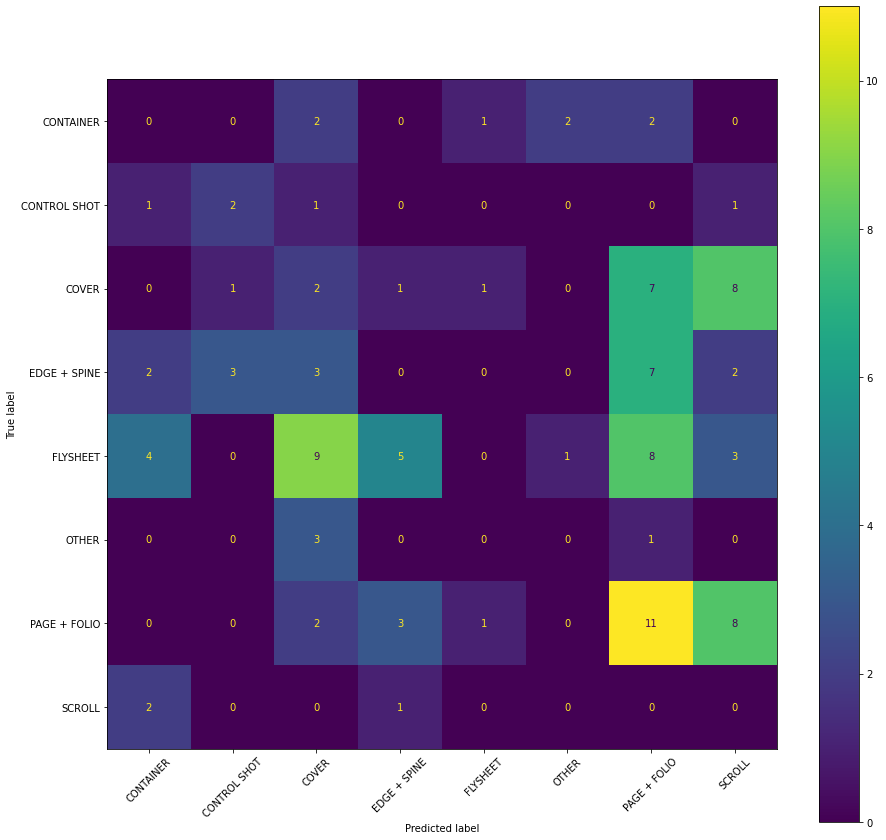

In [ ]:
plot_confusion_matrix(outputs,trainer)

In [ ]:
#export
def create_classification_report(outputs, trainer):
    from sklearn.metrics import classification_report
    y_true = outputs.label_ids
    y_pred = outputs.predictions.argmax(1)
    labels =trainer.model.config.id2label.values()
    return classification_report(y_true, y_pred, target_names=labels, output_dict=True)

In [ ]:
results = create_classification_report(outputs, trainer,)

In [ ]:
print(results)

{
    'CONTAINER': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7},
    'CONTROL SHOT': {
        'precision': 0.3333333333333333,
        'recall': 0.4,
        'f1-score': 0.3636363636363636,
        'support': 5
    },
    'COVER': {
        'precision': 0.09090909090909091,
        'recall': 0.1,
        'f1-score': 0.09523809523809525,
        'support': 20
    },
    'EDGE + SPINE': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 17},
    'FLYSHEET': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 30},
    'OTHER': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4},
    'PAGE + FOLIO': {
        'precision': 0.3055555555555556,
        'recall': 0.44,
        'f1-score': 0.36065573770491804,
        'support': 25
    },
    'SCROLL': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3},
    'accuracy': 0.13513513513513514,
    'macro avg': {
        'precision': 0.09122474747474747,
        'recall': 0.1175,
        'f1-score': 0.10244127457242211,
        'support': 111
    },
    'weighted avg': {
        'precision': 0.10021385021385021,
        'recall': 0.13513513513513514,
        'f1-score': 0.11476880329339346,
        'support': 111
    }
}

In [ ]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 256
  Batch size = 4


***** eval metrics *****
  epoch                   =        0.0
  eval_f1                 =     0.0886
  eval_loss               =     2.3309
  eval_runtime            = 0:00:11.86
  eval_samples_per_second =     21.577
  eval_steps_per_second   =      5.394


In [ ]:
# kwargs = {
#         "tasks": "image-classification",
#         "tags": ["image-classification", "vision"],
#     }
   
# #trainer.push_to_hub(**kwargs)

In [ ]:
# misclasified report

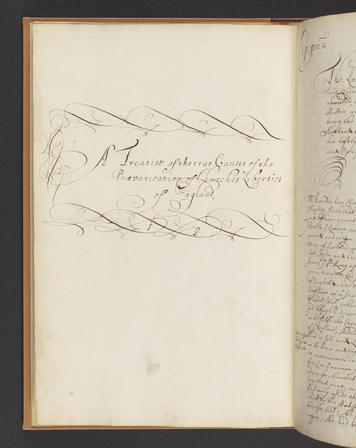

In [ ]:
data.test_ds[0]['image']

In [ ]:
#export
def create_test_results_df(outputs, trainer, important_label=None, print_results=True, return_df=False) -> pd.DataFrame:
    id2label = trainer.model.config.id2label
    y_true = outputs.label_ids
    y_pred = outputs.predictions.argmax(1)
    y_prob = softmax(outputs.predictions, axis=1)
   # ids = test_data['id']
    df = pd.DataFrame({"y_true":y_true,"y_pred": y_pred, "y_prob": y_prob.max(1)})
    df.y_true = df.y_true.map(id2label)
    df.y_pred = df.y_pred.map(id2label)
    if print_results:
        misclassified_df = df[df.y_true != df.y_pred]
        print('misclasified:')
        print(misclassified_df)
        print('\n')
        if important_label:
            print(f"Number of wrong predictions of {important_label} label: {len(misclassified_df[misclassified_df['y_pred']==important_label])}")
            print(f"Percentage of wrong predictions of {important_label} label: {(len(misclassified_df[misclassified_df['y_pred']==important_label])/len(df))*100}")
    if return_df:
        return df


In [ ]:
df = create_test_results_df(outputs, trainer, print_results=True,return_df=True)

misclasified:

y_true        y_pred    y_prob
0        FLYSHEET     CONTAINER  0.195816
2    PAGE + FOLIO        SCROLL  0.347483
3        FLYSHEET         COVER  0.261437
4    PAGE + FOLIO        SCROLL  0.361444
6           COVER        SCROLL  0.312628
..            ...           ...       ...
106  PAGE + FOLIO        SCROLL  0.236326
107  PAGE + FOLIO         COVER  0.195824
108  EDGE + SPINE     CONTAINER  0.261214
109      FLYSHEET         COVER  0.230134
110      FLYSHEET  EDGE + SPINE  0.372495

[96 rows x 3 columns]

In [ ]:
# #export
# @pn.depends(index_selection)
# def get_image(selection):
#     id2label = trainer.config.id2label
#     image = flyswot_data.test_ds[selection]['image']
#     image = pn.Pane(image)
#     row = flyswot_data.test_ds[selection]
#     string_label = id2label[row['label']]
#    # label =  pn.pane.Markdown(f"""actual label: **{string_label}**""")
#     df_row = df.iloc[selection]
#     r = pn.Row(image, pn.Pane(df_row))
#     return r

In [ ]:
#export
def create_mistakes_image_navigator(test_results_df, flyswot_data,trainer):
    import panel as pn
    pn.extension()
    df = test_results_df
    mistakes = df.y_true!=df.y_pred
    mistake_ids = df.index[mistakes].tolist()
    df = df[mistakes]
    df = df.reset_index(drop=True)
    subset = flyswot_data.test_ds.select(mistake_ids)
    assert len(df) == len(subset)
    if len(df)<1:
        print(df)
        return subset['image'][0]
    index_selection = pn.widgets.DiscreteSlider(options=df.index.to_list())
    id2label = trainer.model.config.id2label
    @pn.depends(index_selection)
    def get_image(selection):
        image = subset[selection]['image']
        image = pn.Pane(image)
        #row = flyswot_data.test_ds[selection]
       # string_label = id2label[row['label']]
       # label =  pn.pane.Markdown(f"""actual label: **{string_label}**""")
        df_row = df.iloc[selection]
        r = pn.Row(image, pn.Pane(df_row))
        return r
    df = df.reset_index(drop=True)
    return pn.Column(index_selection,get_image)

In [ ]:
explorer = create_mistakes_image_navigator(df, data,trainer)

Column
    [0] DiscreteSlider(formatter='%d', options=[0, 1, 2, 3, 4, ...], value=0)
    [1] ParamFunction(function)
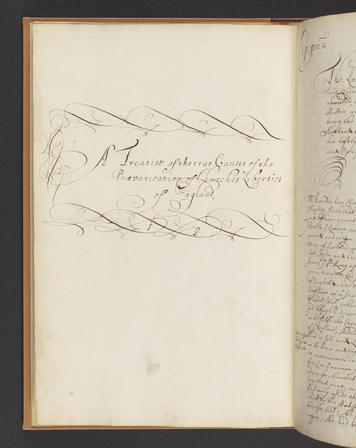

In [ ]:
explorer

In [ ]:
assert explorer

In [ ]:
# index_selection = pn.widgets.DiscreteSlider(options=df.index.to_list())

In [ ]:
# df = df.reset_index(drop=True)

In [ ]:
#export
def create_misclassified_report(outputs, trainer, test_data, important_label=None, print_results=True, return_df=False):
    id2label = trainer.model.config.id2label
    y_true = outputs.label_ids
    y_pred = outputs.predictions.argmax(1)
    y_prob = softmax(outputs.predictions, axis=1)
    df = pd.DataFrame({"y_true":y_true,"y_pred": y_pred, "y_prob": y_prob.max(1)})
    df.y_true = df.y_true.map(id2label)
    df.y_pred = df.y_pred.map(id2label)
    if print_results:
        misclassified_df = df[df.y_true != df.y_pred]
        print('misclasified:')
        print(misclassified_df)
        print('\n')
        if important_label:
            print(f"Number of wrong predictions of {important_label} label: {len(misclassified_df[misclassified_df['y_pred']==important_label])}")
            print(f"Percentage of wrong predictions of {important_label} label: {(len(misclassified_df[misclassified_df['y_pred']==important_label])/len(df))*100}")
    if return_df:
        return misclassified_df


In [ ]:
assert isinstance(df, pd.DataFrame)

In [ ]:
df.y_prob.max()

0.6300906

In [ ]:
df[df['y_pred']=='FLYSHEET']

,y_true,y_pred,y_prob
6,COVER,FLYSHEET,0.197247
16,PAGE + FOLIO,FLYSHEET,0.357923
29,PAGE + FOLIO,FLYSHEET,0.377280
40,COVER,FLYSHEET,0.331381
43,PAGE + FOLIO,FLYSHEET,0.353475
70,SCROLL,FLYSHEET,0.326789
75,COVER,FLYSHEET,0.212558
80,SCROLL,FLYSHEET,0.227946
100,PAGE + FOLIO,FLYSHEET,0.246995
104,CONTROL SHOT,FLYSHEET,0.236295


In [ ]:
df[df['y_pred']=='FLYSHEET'].sort_values('y_prob',ascending=False)

,y_true,y_pred,y_prob
29,PAGE + FOLIO,FLYSHEET,0.377280
16,PAGE + FOLIO,FLYSHEET,0.357923
43,PAGE + FOLIO,FLYSHEET,0.353475
40,COVER,FLYSHEET,0.331381
70,SCROLL,FLYSHEET,0.326789
100,PAGE + FOLIO,FLYSHEET,0.246995
104,CONTROL SHOT,FLYSHEET,0.236295
80,SCROLL,FLYSHEET,0.227946
75,COVER,FLYSHEET,0.212558
6,COVER,FLYSHEET,0.197247


In [ ]:
#trainer.push_to_hub()

In [ ]:
#import pandas as pd

In [ ]:
# y_true = outputs.label_ids
# y_pred = outputs.predictions.argmax(1)
# df = pd.DataFrame({"y_true":y_true,"y_pred": y_pred})